# Estudio de la evolución de la pandemia por el modelo de red neuronal recurrente para la isla de La Palma

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    #plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.show()
    
def visualizar_historico(train, y_test, y_pred, variable, dias_historico, indices, tit, color, dif):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    plt.bar(indices, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    historico = modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=2)
    
    return modelo, historico
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))
        
def visualizar_perdida(historico):
    plt.plot(historico.history['loss'], label='train')
    plt.plot(historico.history['val_loss'], label='test')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.title('Pérdida del modelo')
    plt.legend()
    plt.show() 

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_LaPalma = datos[datos['isla'] == 'LA PALMA']

datos_LaPalma = datos_LaPalma.sort_values(by='fecha') # Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_LaPalma = datos_LaPalma.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'La Palma'         # Isla a la que se está realziando el estudio
fechas = datos_LaPalma.tail(dias_prediccion).index # Fechas de los días a predecir
color_isla = 'darkcyan' # Color de la isla en las visualizaciones
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train

variables_covid = [objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = [objetivo, 'tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = [objetivo,'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables


In [5]:
# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_LaPalma_uni = datos_LaPalma[objetivo]
datos_LaPalma_uni_arr = np.array(datos_LaPalma_uni).reshape(-1, 1)

datos_LaPalma_mult_covid = datos_LaPalma[variables_covid]
datos_LaPalma_mult_atm = datos_LaPalma[variables_atm]
datos_LaPalma_mult_total = datos_LaPalma[variables]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_uni_scaled = scaler.fit_transform(datos_LaPalma_uni_arr)

In [7]:
n_train = len(datos_LaPalma_uni_scaled) - dias_prediccion


train = datos_LaPalma_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaPalma_uni_scaled[n_train - dias_prediccion:len(datos_LaPalma_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0263 - val_loss: 0.0210 - 3s/epoch - 221ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0237 - val_loss: 0.0190 - 124ms/epoch - 9ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0220 - val_loss: 0.0190 - 120ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0198 - val_loss: 0.0160 - 125ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0181 - val_loss: 0.0150 - 125ms/epoch - 9ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0162 - val_loss: 0.0127 - 124ms/epoch - 9ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0142 - val_loss: 0.0116 - 124ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0137 - val_loss: 0.0104 - 124ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0121 - val_loss: 0.0099 - 121ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0115 - val_loss: 0.0096 - 126ms/epoch - 9ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0098 - val_loss: 0.0089 - 124ms/epoch - 9ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0104 - val_loss: 0.0081 - 123ms/epoch - 9ms/step
Epoch 13/40
14/14 - 0s - l

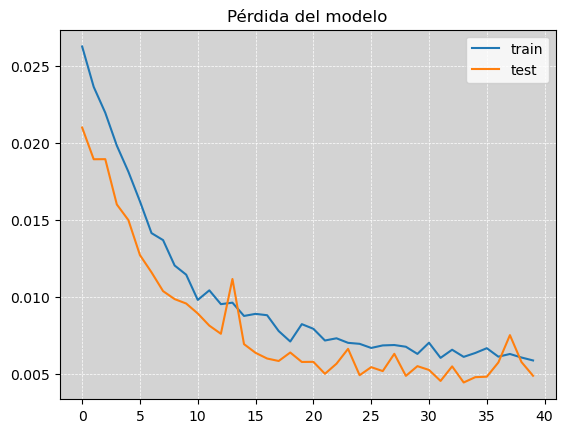

In [10]:
visualizar_perdida(historico)

In [11]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 327ms/step


In [12]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 44, número de casos predichos 76.61276
2022-03-20: número de casos reales 30, número de casos predichos 73.20251
2022-03-21: número de casos reales 127, número de casos predichos 73.061844
2022-03-22: número de casos reales 90, número de casos predichos 71.452286
2022-03-23: número de casos reales 106, número de casos predichos 79.41822
2022-03-24: número de casos reales 70, número de casos predichos 93.50179
2022-03-25: número de casos reales 89, número de casos predichos 87.869865
2022-03-26: número de casos reales 26, número de casos predichos 83.129364
2022-03-27: número de casos reales 15, número de casos predichos 80.55877
2022-03-28: número de casos reales 63, número de casos predichos 75.417305


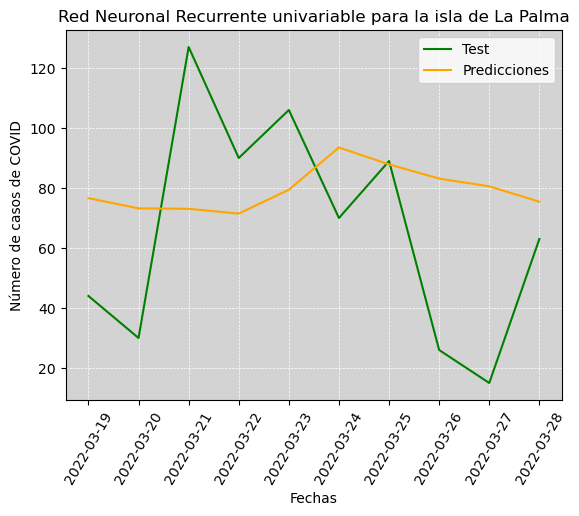

In [13]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [14]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-32.61276245, -43.20250702,  53.93815613,  18.54771423,
        26.58177948, -23.50179291,   1.13013458, -57.12936401,
       -65.55876923, -12.41730499])

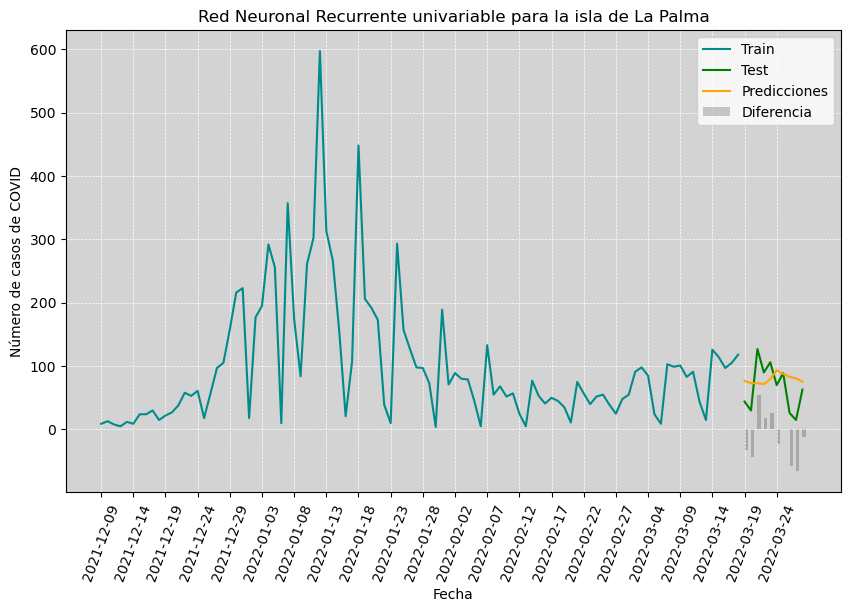

In [15]:
datos_train = datos_LaPalma_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',n_dias_train_vis,fechas,tit,color_isla,dif)

In [16]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 1515.94996698912
Error absoluto medio (MAE) del modelo: 33.46202850341797
Raíz del error cuadrático medio (RMSE) del modelo: 38.93520215677736


# Red Neuronal Recurrente multivariable con variables de pandemia

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_covid_scaled = scaler.fit_transform(datos_LaPalma_mult_covid)


# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaPalma_mult_covid[objetivo]).reshape(-1, 1))

In [18]:
n_train = len(datos_LaPalma_mult_covid_scaled) - dias_prediccion


train = datos_LaPalma_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaPalma_mult_covid_scaled[n_train - dias_prediccion:len(datos_LaPalma_mult_covid_scaled), :]

In [19]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [20]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0355 - val_loss: 0.0289 - 3s/epoch - 226ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0312 - val_loss: 0.0252 - 139ms/epoch - 10ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0281 - val_loss: 0.0234 - 132ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0262 - val_loss: 0.0217 - 134ms/epoch - 10ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0240 - val_loss: 0.0225 - 134ms/epoch - 10ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0222 - val_loss: 0.0196 - 137ms/epoch - 10ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0207 - val_loss: 0.0243 - 132ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0193 - val_loss: 0.0200 - 132ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0176 - val_loss: 0.0178 - 135ms/epoch - 10ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0168 - val_loss: 0.0206 - 142ms/epoch - 10ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0160 - val_loss: 0.0151 - 131ms/epoch - 9ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0146 - val_loss: 0.0162 - 131ms/epoch - 9ms/step
Epoch 13/40
14/14 - 

In [21]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-76.53906061, -76.56251119, -76.40003213, -76.46200868,
       -76.43520801, -76.49550952, -76.46368372, -76.56921136,
       -76.58763682, -76.50723481, -73.12880518, -73.15225576,
       -72.9897767 , -73.05175325, -73.02495258, -73.08525409,
       -73.05342829, -73.15895593, -73.17738139, -73.09697938,
       -72.98814203, -73.01159262, -72.84911355, -72.9110901 ,
       -72.88428943, -72.94459094, -72.91276515, -73.01829278,
       -73.03671824, -72.95631623, -71.37858392, -71.40203451,
       -71.23955545, -71.301532  , -71.27473133, -71.33503284,
       -71.30320704, -71.40873468, -71.42716014, -71.34675813,
       -79.34451868, -79.36796926, -79.2054902 , -79.26746675,
       -79.24066608, -79.30096759, -79.26914179, -79.37466943,
       -79.39309489, -79.31269288, -93.42809107, -93.45154165,
       -93.28906259, -93.35103914, -93.32423847, -93.38453998,
       -93.35271418, -93.45824182, -93.47666728, -93.39626527,
       -87.79616357, -87.81961416, -87.6571351 , -87.71

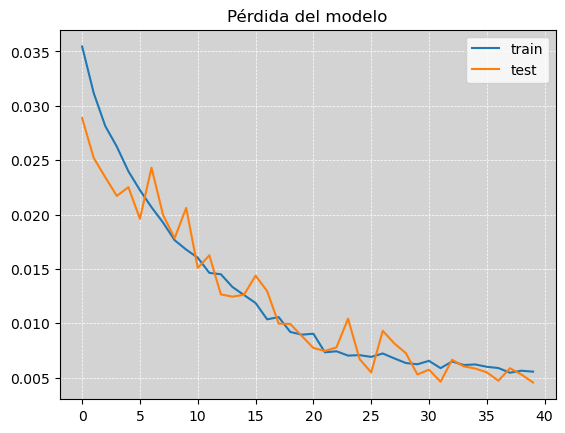

In [22]:
visualizar_perdida(historico)

In [23]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 302ms/step


In [24]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 44, número de casos predichos 48.133617
2022-03-20: número de casos reales 30, número de casos predichos 53.079597
2022-03-21: número de casos reales 127, número de casos predichos 50.276638
2022-03-22: número de casos reales 90, número de casos predichos 50.58701
2022-03-23: número de casos reales 106, número de casos predichos 57.670063
2022-03-24: número de casos reales 70, número de casos predichos 70.00864
2022-03-25: número de casos reales 89, número de casos predichos 65.4101
2022-03-26: número de casos reales 26, número de casos predichos 59.01111
2022-03-27: número de casos reales 15, número de casos predichos 59.929714
2022-03-28: número de casos reales 63, número de casos predichos 58.01663


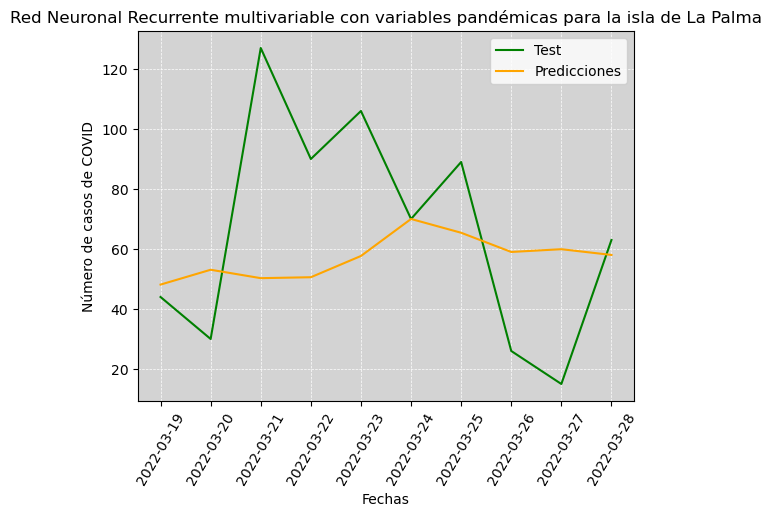

In [25]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [26]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-4.13361740e+00, -2.30795975e+01,  7.67233620e+01,  3.94129906e+01,
        4.83299370e+01, -8.63647461e-03,  2.35898972e+01, -3.30111084e+01,
       -4.49297142e+01,  4.98337173e+00])

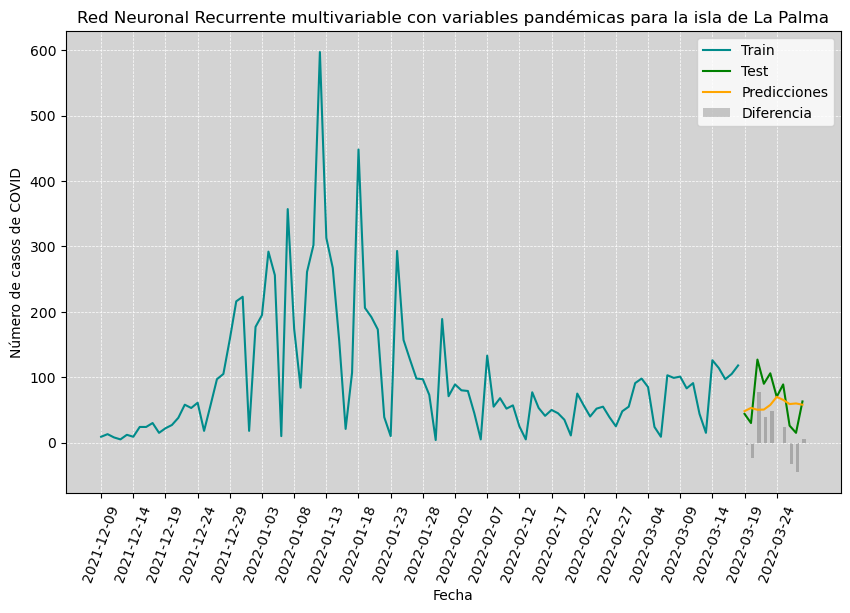

In [27]:
datos_train = datos_LaPalma_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [28]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 1401.5125330749172
Error absoluto medio (MAE) del modelo: 29.820223236083983
Raíz del error cuadrático medio (RMSE) del modelo: 37.436780484904375


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_atm_scaled = scaler.fit_transform(datos_LaPalma_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaPalma_mult_atm[objetivo]).reshape(-1, 1))

In [30]:
n_train = len(datos_LaPalma_mult_atm_scaled) - dias_prediccion


train = datos_LaPalma_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaPalma_mult_atm_scaled[n_train - dias_prediccion:len(datos_LaPalma_mult_atm_scaled), :]

In [31]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [32]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0318 - val_loss: 0.0273 - 3s/epoch - 221ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0290 - val_loss: 0.0227 - 131ms/epoch - 9ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0267 - val_loss: 0.0202 - 130ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0245 - val_loss: 0.0185 - 130ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0231 - val_loss: 0.0172 - 134ms/epoch - 10ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0208 - val_loss: 0.0161 - 132ms/epoch - 9ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0193 - val_loss: 0.0172 - 130ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0183 - val_loss: 0.0139 - 132ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0166 - val_loss: 0.0130 - 130ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0150 - val_loss: 0.0123 - 131ms/epoch - 9ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0141 - val_loss: 0.0119 - 131ms/epoch - 9ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0133 - val_loss: 0.0112 - 130ms/epoch - 9ms/step
Epoch 13/40
14/14 - 0s - 

In [33]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-48.05991556, -48.08336614, -47.92088708, -47.98286363,
       -47.95606296, -48.01636447, -47.98453867, -48.09006631,
       -48.10849177, -48.02808976, -53.00589563, -53.02934622,
       -52.86686715, -52.9288437 , -52.90204303, -52.96234454,
       -52.93051875, -53.03604638, -53.05447185, -52.97406983,
       -50.20293619, -50.22638677, -50.06390771, -50.12588426,
       -50.09908359, -50.1593851 , -50.1275593 , -50.23308694,
       -50.2515124 , -50.17111039, -50.51330759, -50.53675817,
       -50.37427911, -50.43625566, -50.40945499, -50.4697565 ,
       -50.4379307 , -50.54345834, -50.5618838 , -50.48148179,
       -57.59636118, -57.61981176, -57.4573327 , -57.51930925,
       -57.49250858, -57.55281009, -57.52098429, -57.62651193,
       -57.64493739, -57.56453538, -69.93493463, -69.95838522,
       -69.79590616, -69.85788271, -69.83108204, -69.89138354,
       -69.85955775, -69.96508539, -69.98351085, -69.90310884,
       -65.336401  , -65.35985159, -65.19737253, -65.25

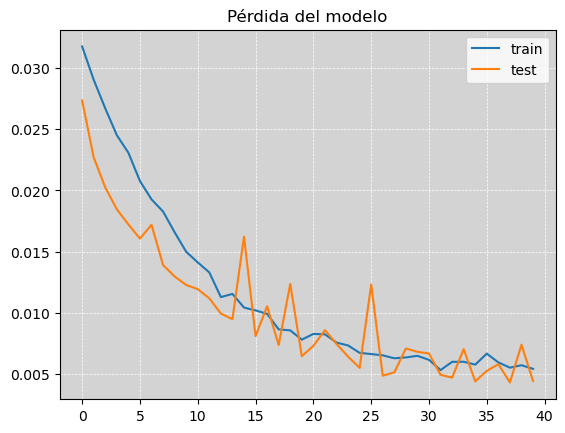

In [34]:
visualizar_perdida(historico)

In [35]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 1s 506ms/step


In [36]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 44, número de casos predichos 73.06767
2022-03-20: número de casos reales 30, número de casos predichos 69.120544
2022-03-21: número de casos reales 127, número de casos predichos 69.09445
2022-03-22: número de casos reales 90, número de casos predichos 68.56617
2022-03-23: número de casos reales 106, número de casos predichos 76.67109
2022-03-24: número de casos reales 70, número de casos predichos 88.78675
2022-03-25: número de casos reales 89, número de casos predichos 81.76595
2022-03-26: número de casos reales 26, número de casos predichos 77.58045
2022-03-27: número de casos reales 15, número de casos predichos 74.9309
2022-03-28: número de casos reales 63, número de casos predichos 68.75112


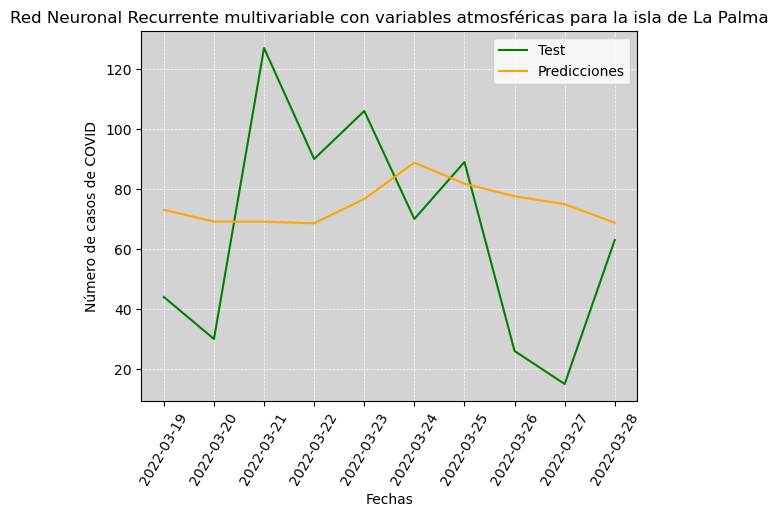

In [37]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [38]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-29.06767273, -39.12054443,  57.9055481 ,  21.43383026,
        29.32891083, -18.78675079,   7.23404694, -51.58045197,
       -59.93090057,  -5.75112152])

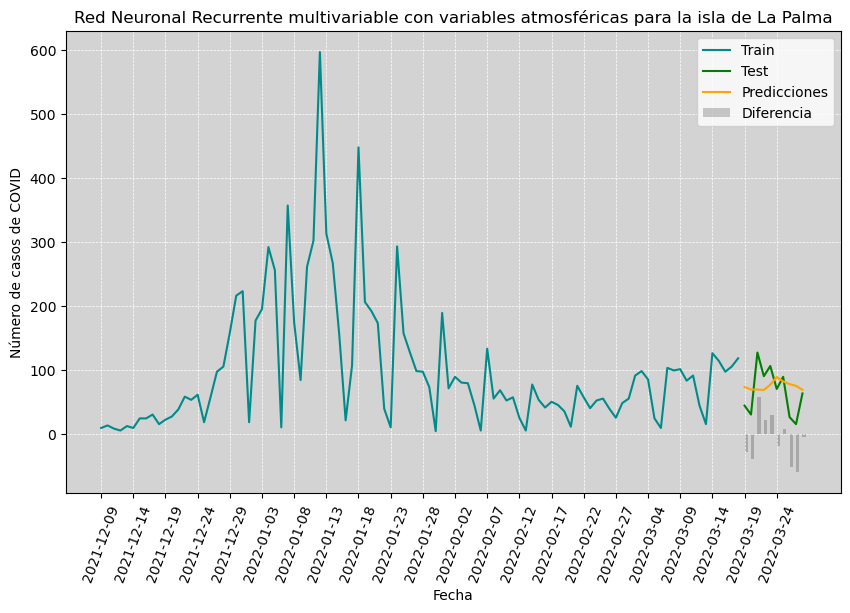

In [39]:
datos_train = datos_LaPalma_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [40]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 1373.8597892679913
Error absoluto medio (MAE) del modelo: 32.0139778137207
Raíz del error cuadrático medio (RMSE) del modelo: 37.065614648458094


# Red Neuronal Recurrente multivariable con todas las variables

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_total_scaled = scaler.fit_transform(datos_LaPalma_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaPalma_mult_total[objetivo]).reshape(-1, 1))

In [42]:
n_train = len(datos_LaPalma_mult_total_scaled) - dias_prediccion


train = datos_LaPalma_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaPalma_mult_total_scaled[n_train - dias_prediccion:len(datos_LaPalma_mult_total_scaled), :]

In [43]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [44]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0292 - val_loss: 0.0219 - 3s/epoch - 224ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0256 - val_loss: 0.0210 - 163ms/epoch - 12ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0232 - val_loss: 0.0202 - 157ms/epoch - 11ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0212 - val_loss: 0.0202 - 155ms/epoch - 11ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0196 - val_loss: 0.0189 - 158ms/epoch - 11ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0178 - val_loss: 0.0208 - 155ms/epoch - 11ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0166 - val_loss: 0.0187 - 155ms/epoch - 11ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0153 - val_loss: 0.0285 - 158ms/epoch - 11ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0142 - val_loss: 0.0228 - 157ms/epoch - 11ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0131 - val_loss: 0.0175 - 158ms/epoch - 11ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0122 - val_loss: 0.0205 - 155ms/epoch - 11ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0117 - val_loss: 0.0291 - 157ms/epoch - 11ms/step
Epoch 13/40
14/

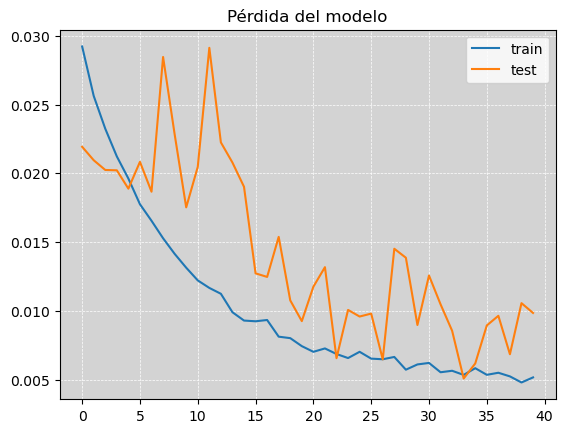

In [45]:
visualizar_perdida(historico)

In [46]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 305ms/step


In [47]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 44, número de casos predichos 106.64642
2022-03-20: número de casos reales 30, número de casos predichos 110.34804
2022-03-21: número de casos reales 127, número de casos predichos 103.85978
2022-03-22: número de casos reales 90, número de casos predichos 99.95875
2022-03-23: número de casos reales 106, número de casos predichos 110.25797
2022-03-24: número de casos reales 70, número de casos predichos 130.09253
2022-03-25: número de casos reales 89, número de casos predichos 123.906845
2022-03-26: número de casos reales 26, número de casos predichos 111.43709
2022-03-27: número de casos reales 15, número de casos predichos 105.20832
2022-03-28: número de casos reales 63, número de casos predichos 97.38428


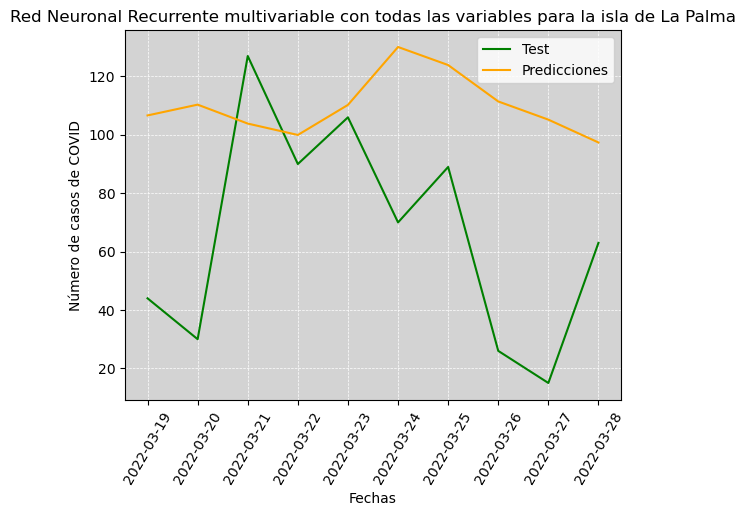

In [48]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [49]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-62.64642334, -80.34803772,  23.14022064,  -9.95874786,
        -4.25797272, -60.0925293 , -34.90684509, -85.43708801,
       -90.20832062, -34.38427734])

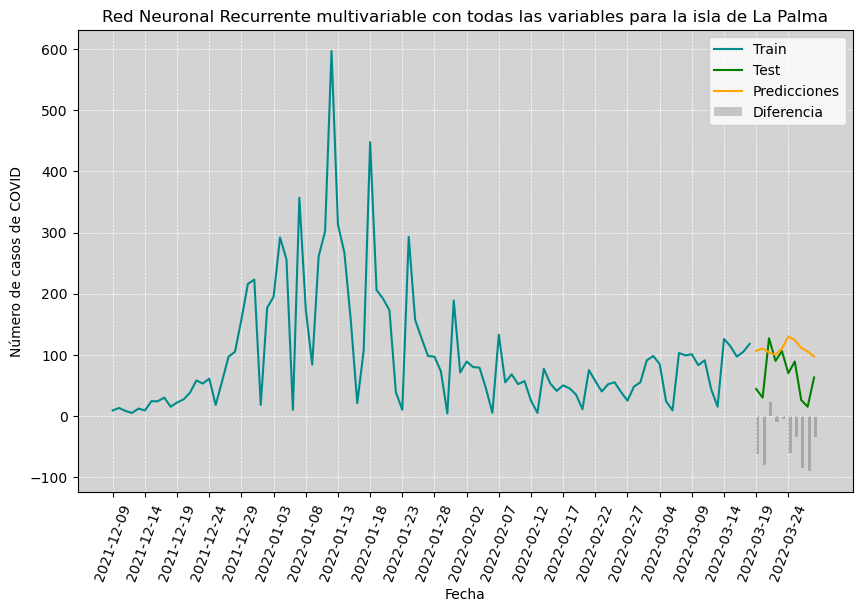

In [50]:
datos_train = datos_LaPalma_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [51]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 3248.2073881554415
Error absoluto medio (MAE) del modelo: 48.538046264648436
Raíz del error cuadrático medio (RMSE) del modelo: 56.99304684042994
